In [1]:
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchmetrics import Accuracy

import torch.optim as optim
from cleverhans.torch.attacks.projected_gradient_descent import (projected_gradient_descent)

import quantus
import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import copy
import gc
import math

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

from resnet_18 import *


In [2]:
print(torch.cuda.is_available())

True


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
%run utils.ipynb

In [42]:
# %run resnet_18.ipynb

In [5]:
batch_size = 8
train_path = '../datasets/imagenette2/train'
val_path = '../datasets/imagenette2/val'

In [6]:
train_dataloader = DataLoader(datasets.ImageFolder(train_path, transform = transforms.Compose([
                                                                    transforms.RandomResizedCrop(224),
                                                                    transforms.RandomHorizontalFlip(),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                        std=[0.229, 0.224, 0.225])
                                                            ])), batch_size = batch_size, shuffle=True, num_workers=4, pin_memory=True)

test_dataloader = DataLoader(datasets.ImageFolder(val_path,
                                                               transform=transforms.Compose([
                                                                   transforms.ToTensor(),
                                                                   transforms.Resize([224, 224]),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                        std=[0.229, 0.224, 0.225])
                                                               ])),batch_size=batch_size, shuffle=True,num_workers=4, pin_memory=True)


In [7]:
classes = ['tench', 'springer', 'casette_player', 'chain_saw','church', 'French_horn', 'garbage_truck', 'gas_pump', 'golf_ball', 'parachute']


In [8]:
criterion = nn.CrossEntropyLoss(reduction="mean").cuda()

In [9]:
MODEL_PATH = "saves/resnet/imagenette/0_model_lt.pth.tar"
model = torch.load(MODEL_PATH, map_location=device, weights_only=False)
model.eval()
accuracy = test(model, test_dataloader, criterion)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 84.15%


In [50]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0903845..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9381683..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6524969..2.6169603].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9662478..2.5806072].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1069386..2.6400006].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6524969..2.6169603].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8093859..2.64000

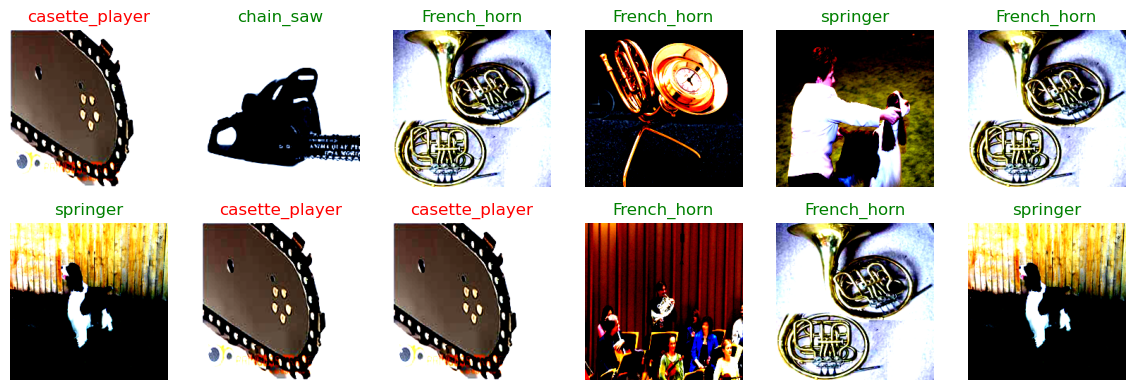

In [51]:

fig = plt.figure(figsize=(12, 4))
indexes=[]
rows, cols = 2, 6
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(x_batch), size=[1]).item()
    img, label_gt = x_batch[random_idx], y_batch[random_idx]
    indexes.append(random_idx)
    img_temp = img.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = torch.argmax(model(img_temp))
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)    # CWH --> WHC
    
    plt.imshow(img.cpu().numpy(), cmap='gray')
    if label_pred == label_gt:
        plt.title(classes[label_pred], color='g') # for correct prediction
    else:
        plt.title(classes[label_pred], color='r') # for incorrect prediction
    plt.axis(False)
    plt.tight_layout();
plt.show()

In [52]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [54]:
gc.collect()
torch.cuda.empty_cache()
a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9662478..2.5806072].


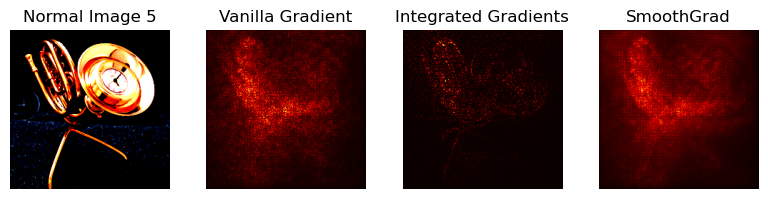

In [55]:
index = indexes[3]
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_normal')

## Pruned 1 Model

In [56]:
MODEL_PATH = "saves/resnet/imagenette/1_model_lt.pth.tar"
model = torch.load(MODEL_PATH, map_location=device, weights_only=False)
model.eval()
accuracy = test(model, test_dataloader, criterion)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 84.31%


In [57]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [58]:
a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9662478..2.5806072].


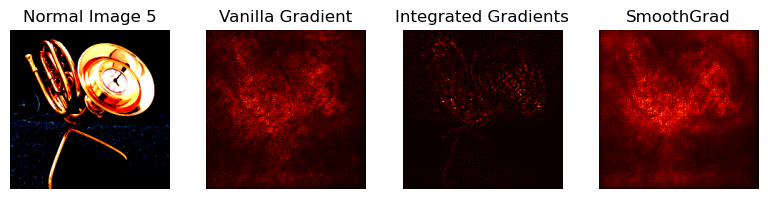

In [59]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_1')

## Pruned 2nd Model

Test Accuracy: 85.55%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9662478..2.5806072].


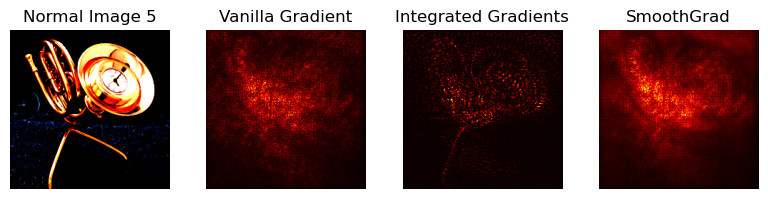

In [60]:
MODEL_PATH = "saves/resnet/imagenette/2_model_lt.pth.tar"
model = torch.load(MODEL_PATH, map_location=device, weights_only=False)
model.eval()
accuracy = test(model, test_dataloader, criterion)
print(f"Test Accuracy: {accuracy:.2f}%")

gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_2')

## Pruned 3 Model

Test Accuracy: 85.63%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9662478..2.5806072].


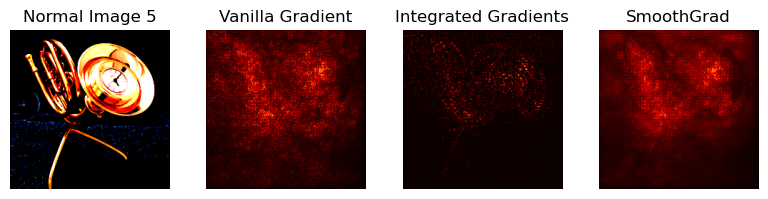

In [61]:
MODEL_PATH = "saves/resnet/imagenette/6_model_lt.pth.tar"
model = torch.load(MODEL_PATH, map_location=device, weights_only=False)
model.eval()
accuracy = test(model, test_dataloader, criterion)
print(f"Test Accuracy: {accuracy:.2f}%")

gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_3')

## Pruned 4 Model

Test Accuracy: 84.43%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9662478..2.5806072].


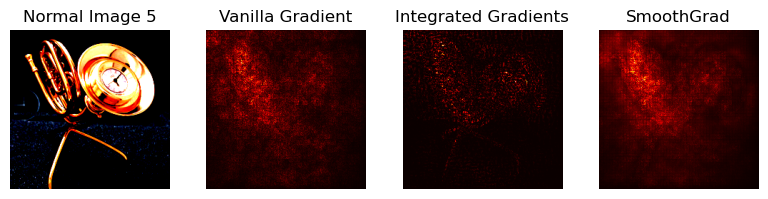

In [62]:
MODEL_PATH = "saves/resnet/imagenette/12_model_lt.pth.tar"
model = torch.load(MODEL_PATH, map_location=device, weights_only=False)
model.eval()
accuracy = test(model, test_dataloader, criterion)
print(f"Test Accuracy: {accuracy:.2f}%")

gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_4')

## Pruned 5 Model

Test Accuracy: 82.70%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9662478..2.5806072].


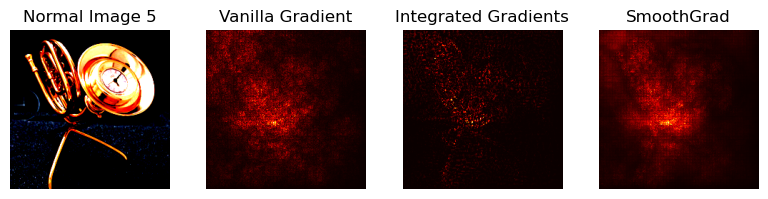

In [63]:
MODEL_PATH = "saves/resnet/imagenette/18_model_lt.pth.tar"
model = torch.load(MODEL_PATH, map_location=device, weights_only=False)
model.eval()
accuracy = test(model, test_dataloader, criterion)
print(f"Test Accuracy: {accuracy:.2f}%")

gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_5')

## Pruned 6 Model

Test Accuracy: 83.46%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9662478..2.5806072].


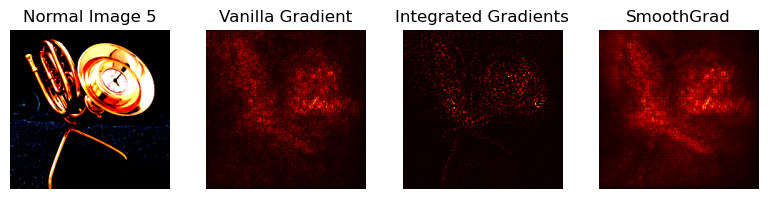

In [64]:
MODEL_PATH = "saves/resnet/imagenette/29_model_lt.pth.tar"
model = torch.load(MODEL_PATH, map_location=device, weights_only=False)
model.eval()
accuracy = test(model, test_dataloader, criterion)
print(f"Test Accuracy: {accuracy:.2f}%")

gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_6')

In [10]:
%run metrics.ipynb

In [11]:
def explainer_wrapper(**kwargs):
    """
    A wrapper function to call the appropriate explanation method.

    """
    if kwargs["method"] == "SmoothGrad":
        return smoothgrad_explainer(**kwargs)
    else:
        return ValueError("Explanation function doesnt exist")



def smoothgrad_explainer(model, inputs, targets, abs=True, normalise=True, stdevs=0.15, nt_samples=10, *args, **kwargs):
    """
    Generate explanations for a model's predictions using the SmoothGrad method.

    Args:
        model: The model to explain.
        inputs : Input samples.
        targets: Target labels corresponding to the inputs.
        abs : Whether to use the absolute value of gradients.
        normalise: Whether to normalize the explanation
        stdevs: Standard deviation of the noise added to inputs
        nt_samples: Number of noisy samples to generate for SmoothGrad.

    Returns:
        numpy.ndarray: Explanation maps for the input samples.
    """
    std = kwargs.get("std", 0.15)  # Standard deviation for input noise
    n = kwargs.get("n", 10)  # Number of noisy samples
    clip = kwargs.get("clip", False)

    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1,kwargs.get("nr_channels", 3),kwargs.get("img_size", 224),kwargs.get("img_size", 224),).to(kwargs.get("device", None))
        )
    
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (len(np.shape(inputs)) == 4), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size"

    if inputs.shape[0] > 1:
        explanation = torch.zeros(
            (
                n,
                inputs.shape[0],
                kwargs.get("img_size", 224),
                kwargs.get("img_size", 224),
            )
        )
    else:
        explanation = torch.zeros(
            (n, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
        )
    saliency = Saliency(model)
    
    explanation = (
        NoiseTunnel(saliency)
        .attribute(inputs=inputs, target=targets, nt_type="smoothgrad", stdevs = stdevs, nt_samples= 10)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
        .cpu()
        .data
    )

    # explanation = explanation.mean(axis=0)
    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    # Normalization (if required)
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    # Convert the result to NumPy if it is still a PyTorch tensor
    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation

In [12]:
xai_method=["SmoothGrad"]
gc.collect()
torch.cuda.empty_cache()

In [13]:
result_normal = filter_and_compute_road(model, test_dataloader, "Saliency", device, resnet = True)
print("The road score is: ", result_normal)

The road score is:  {1: np.float64(0.9855275918921534), 11: np.float64(0.9278173794976224), 21: np.float64(0.8860367568616029), 31: np.float64(0.8314857918727565), 41: np.float64(0.7698525846183695), 51: np.float64(0.702965279798275), 61: np.float64(0.6229366695761822), 71: np.float64(0.5245078071961984), 81: np.float64(0.42292212200562507), 91: np.float64(0.3035980991174474)}


In [ ]:
result_normal_ig = filter_and_compute_road(model, test_dataloader,"IntegratedGradients", device, resnet = True)
print("The road score is: ", result_normal_ig)

In [ ]:
result_normal_smooth = filter_and_compute_road(model, test_dataloader, "SmoothGrad",device, resnet = True)
print("The road score is: ", result_normal_smooth)

In [ ]:
normal_sparse_saliency = filter_and_compute_sparsity(model, test_dataloader,"Saliency", device, resnet = True)
print("The sparsity score is: ", normal_sparse_saliency)

In [ ]:
normal_sparse_ig =  filter_and_compute_sparsity(model, test_dataloader,"IntegratedGradients", device, resnet = True)
print("The sparsity score is: ",normal_sparse_ig)


In [ ]:
normal_sparse_smooth = filter_and_compute_sparsity(model, test_dataloader,"SmoothGrad", device, resnet = True)
print("The sparsity score is: ",normal_sparse_smooth )

In [ ]:
result_aopc = compute_aopc_morf({model})

In [17]:
normal_sparse_saliency = 0.4225200890204471
normal_sparse_ig = 0.5886364333326195
normal_sparse_smooth = 0.35203885093684967

prune_1_sparse_saliency = 0.4646376142622848
prune_1_sparse_ig = 0.6071415289691077
prune_1_sparse_smooth =0.3931358765839972

prune_2_sparse_saliency = 0.46837122128811204
prune_2_sparse_ig = 0.6066886995654848
prune_2_sparse_smooth =  0.4015182269579882

prune_3_sparse_saliency =0.4580060560186745
prune_3_sparse_ig =0.6081427072268425
prune_3_sparse_smooth =0.3831316270456178

prune_4_sparse_saliency = 0.45473032477062864
prune_4_sparse_ig = 0.6112264423854529
prune_4_sparse_smooth =0.3855975741454674

prune_5_sparse_saliency = 0.4541549643816636
prune_5_sparse_ig = 0.6093546384460925
prune_5_sparse_smooth = 0.38295188272288805

prune_6_sparse_saliency =0.4456104998079535
prune_6_sparse_ig =0.6017133352785186
prune_6_sparse_smooth =0.36623962437370344

prune_7_sparse_saliency =0.44388624278818267
prune_7_sparse_ig = 0.5999048563523421
prune_7_sparse_smooth = 0.3640059154190342

prune_8_sparse_saliency = 0.4485468770764859
prune_8_sparse_ig = 0.5978818542489692
prune_8_sparse_smooth =  0.3788215009578745

prune_9_sparse_saliency = 0.4480548349520132
prune_9_sparse_ig = 0.595999840949814
prune_9_sparse_smooth = 0.3722728643213538

In [18]:
vanilla_gradient = [normal_sparse_saliency, prune_1_sparse_saliency, prune_2_sparse_saliency, prune_3_sparse_saliency, prune_4_sparse_saliency, prune_5_sparse_saliency, prune_6_sparse_saliency,prune_7_sparse_saliency ,prune_8_sparse_saliency,prune_9_sparse_saliency ]
integrated_gradients = [normal_sparse_ig, prune_1_sparse_ig, prune_2_sparse_ig, prune_3_sparse_ig, prune_4_sparse_ig,prune_5_sparse_ig  ,prune_6_sparse_ig,prune_7_sparse_ig , prune_8_sparse_ig,prune_9_sparse_ig ]
smoothgrad = [normal_sparse_smooth, prune_1_sparse_smooth, prune_2_sparse_smooth, prune_3_sparse_smooth, prune_4_sparse_smooth,prune_5_sparse_smooth , prune_6_sparse_smooth,prune_7_sparse_smooth ,prune_8_sparse_smooth ,prune_9_sparse_smooth]

row_labels = ["Normal Model", "Pruned 1 Model", "Pruned 2 Model", "Pruned 3 Model", "Pruned 4 Model","Pruned 5 Model", "Pruned 6 Model", "Pruned 7 Model","Pruned 8 Model", "Pruned 9 Model"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}])

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,0.422520,0.588636,0.352039
Pruned 1 Model,0.464638,0.607142,0.393136
Pruned 2 Model,0.468371,0.606689,0.401518
Pruned 3 Model,0.458006,0.608143,0.383132
Pruned 4 Model,0.454730,0.611226,0.385598
Pruned 5 Model,0.454155,0.609355,0.382952
Pruned 6 Model,0.445610,0.601713,0.366240
Pruned 7 Model,0.443886,0.599905,0.364006
Pruned 8 Model,0.448547,0.597882,0.378822
Pruned 9 Model,0.448055,0.596000,0.372273


In [19]:
result_normal = {1: np.float64(0.9854187562209861), 11: np.float64(0.9302623147929386), 21: np.float64(0.8855254694918366), 31: np.float64(0.8275752431472999), 41: np.float64(0.7686531744591676), 51: np.float64(0.7003263311118203), 61: np.float64(0.6167151750011796), 71: np.float64(0.5189097090335428), 81: np.float64(0.41946263606951006), 91: np.float64(0.30242259808422944)}

result_5 = {1: np.float64(0.9837310536786187), 11: np.float64(0.929972869715964), 21: np.float64(0.866104104853331), 31: np.float64(0.8072800443816678), 41: np.float64(0.7171702227608943), 51: np.float64(0.6231640628883724), 61: np.float64(0.5228790319156869), 71: np.float64(0.4260239943928879), 81: np.float64(0.3296042879105286), 91: np.float64(0.2543334457371799)}

result_10 = {1: np.float64(0.9799208963778208), 11: np.float64(0.9136983714162727), 21: np.float64(0.8637160553598301), 31: np.float64(0.8006494027445334), 41: np.float64(0.7237594767473243), 51: np.float64(0.6276571377706955), 61: np.float64(0.5362060711547837), 71: np.float64(0.43228985890760535), 81: np.float64(0.3291858131864658), 91: np.float64(0.25164405727791406)}

result_15 = {1: np.float64(0.9800060568550581), 11: np.float64(0.9197179038239468), 21: np.float64(0.8670742404008076), 31: np.float64(0.8091293294324844), 41: np.float64(0.7264244267648965), 51: np.float64(0.6474040927489494), 61: np.float64(0.5544084061680202), 71: np.float64(0.4606913360362517), 81: np.float64(0.3678827795588879), 91: np.float64(0.2800112830488548)}

result_20 = {1: np.float64(0.9815317446919453), 11: np.float64(0.916264309570018), 21: np.float64(0.8550035656800294), 31: np.float64(0.78959464373224), 41: np.float64(0.7143713719788255), 51: np.float64(0.6170017447664645), 61: np.float64(0.535769578517576), 71: np.float64(0.440189077713297), 81: np.float64(0.34097142622121834), 91: np.float64(0.2647278476711539)}

result_30 = {1: np.float64(0.9820257658315142), 11: np.float64(0.9274665111306769), 21: np.float64(0.8728924914795306), 31: np.float64(0.8038201046585481), 41: np.float64(0.7230428491972497), 51: np.float64(0.6394828207378183), 61: np.float64(0.5341273658014597), 71: np.float64(0.42564235011338775), 81: np.float64(0.33250923822599016), 91: np.float64(0.24350088953506518)}

result_40 = {1: np.float64(0.9815523567285375), 11: np.float64(0.9356981658686606), 21: np.float64(0.8902092786831333), 31: np.float64(0.8415169642088424), 41: np.float64(0.7749564670168705), 51: np.float64(0.6978569255157439), 61: np.float64(0.60888594593442), 71: np.float64(0.5116983727967653), 81: np.float64(0.4039617397451793), 91: np.float64(0.3028486530926366)}

result_50 =  {1: np.float64(0.9835630670525478), 11: np.float64(0.9342213103810895), 21: np.float64(0.8821054857545466), 31: np.float64(0.8255040473880926), 41: np.float64(0.7546564625140637), 51: np.float64(0.6619870188715149), 61: np.float64(0.5630498173438654), 71: np.float64(0.46577110960962625), 81: np.float64(0.3588333885456528), 91: np.float64(0.25681642034993374)}

result_60 = {1: np.float64(0.9847261184524104), 11: np.float64(0.9267461343208111), 21: np.float64(0.8685318018749423), 31: np.float64(0.807615101667683), 41: np.float64(0.7248794158224089), 51: np.float64(0.6496159754595252), 61: np.float64(0.5688044644775477), 71: np.float64(0.475189554305934), 81: np.float64(0.3775650117210429), 91: np.float64(0.28272291065287086)}

result_70 = {1: np.float64(0.9860395021377726), 11: np.float64(0.9380568182055771), 21: np.float64(0.8859509869049661), 31: np.float64(0.8254678674765173), 41: np.float64(0.7475342621319393), 51: np.float64(0.651121103479216), 61: np.float64(0.5477292968705794), 71: np.float64(0.446885111033178), 81: np.float64(0.34203169419053664), 91: np.float64(0.24484063846912646)}


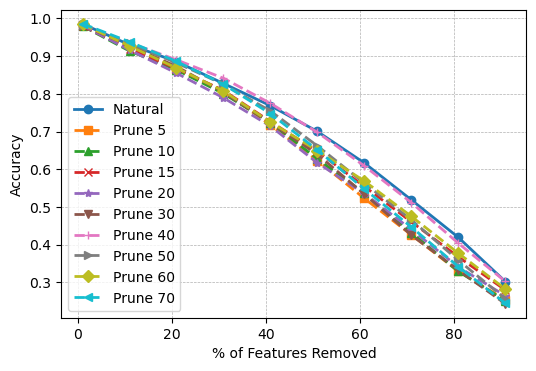

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_5.values()), label='Prune 5', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_10.values()), label='Prune 10', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_15.values()), label='Prune 15', linestyle='--', marker='x', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_20.values()), label='Prune 20', linestyle='--', marker='*', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_30.values()), label='Prune 30', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_40.values()), label='Prune 40', linestyle='--', marker='+', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_50.values()), label='Prune 50', linestyle='--', marker='>', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_60.values()), label='Prune 60', linestyle='--', marker='D', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_70.values()), label='Prune 70', linestyle='--', marker='<', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/RESNET_IMAGENETTE_VANILLA_SALIENCY_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()